The following code just sets up this notebook environment. Just run it and then ignore it.

In [2]:
# Execute this cell once to setup the notebook environment, then ignore it

# set the path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# load the notebook's style sheet
from IPython.core.display import HTML
css_file = 'style.css'
HTML(open(css_file, "r").read())

# embed plots
%matplotlib inline

from regression import introduction

# Introduction to Regression

Let's take a look at the following this dataset.

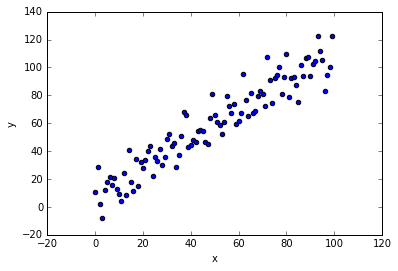

In [3]:
x, y = introduction.generate_linear_data(slope=1, intercept=10, noise_std=10)
introduction.plot(x, y)

If you had to represent all these data points in one single line, how would the line would look like?
Well, that's what a linear regression does: It finds the line whose distance to all the datapoints is minimum. These distace are called residuals.

Concretelly, in the above dataset a linear regression is a linear function of the type: 

$$f(x) = \theta_0 + \theta_1 \cdot x$$

where $\theta_0$ and $\theta_1$ are the coefficients that set the position and slope of the linear function. Now the question is, how do we find the $\theta_0$ and $\theta_1$ that minimize the residuals? One option is to try different values for $\theta_0$ and $\theta_1$ until we find the one that minimizes these residuals.

Well, let's to do that.

In the below box, find the values of $\theta_0$ and $\theta_1$ that minimize the residuals. Keep in mind that when the position of the line is too high, then $\theta_0$ should be lower, and when the slope is too high, then $\theta_1$ should be lower. This also applies in the oposite scenario.

As an example, we start with $\theta_0 = 60$ and $\theta_1 = 0.08$:

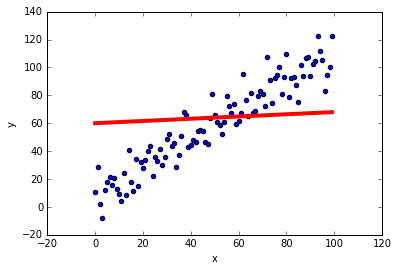

Summation of residuals is 2,488.19


In [4]:
theta0 = 60
theta1 = 0.08

predictions = theta0 + theta1*x
introduction.plot(x, y, predictions)
introduction.print_residuals(y, predictions)

It turns out that there is no need to randomly try different values. Let's say that we start with random values $\theta_0$ and $\theta_1$ and that we somehow we can learn if these values need to increase or decrease, and what should be the magnitude of that increase or decrease. Then, after we update these values, we do that again. This goes on until $\theta_0$ and $\theta_1$ are the coefficients that minimize the distance between the datapoints and our line (i.e. the optimal coefficients).

In general this procedure is called an algorithm. In particular this algorithm is called gradient descent.

Before we dive into gradient descent we need to define what are we trying to minimize here.


## Cost Function

In our example, we were trying to minimize the residuals, i.e. distances between all datapoints and our line, and that is a function of the parameters $\theta_0$ and $\theta_1$. We call that function $J(\theta_0, \theta_1)$.

Does that makes sense? think about it... when we updated $\theta_0$ and $\theta_1$ the distance between the datapoints and the line was modified. It bacame smaller at the beggining until we missed the optimum values for $\theta_0$ and $\theta_1$ and then it became larger again. That is us poking with $J(\theta_0, \theta_1)$ by testing different values of $\theta_0$ and $\theta_1$. We were trying to find the optimal (minimum) value.

In our example, $J(\theta_0, \theta_1)$ was defined as the summation of the residuals, which is equal to:

$$J(\theta_0, \theta_1) = |y_1 - f(x_1)| + |y_2 - f(x_2)| +...+ |y_n - f(x_n)|$$

where n is the number of datapoints in the training set. If we expand $f(x)$ we get:

$$J(\theta_0, \theta_1) = |y_1 - (\theta_0 + \theta_1 \cdot x_1)| + |y_2 - (\theta_0 + \theta_1 \cdot x_1)| +...+ |y_n - (\theta_0 + \theta_1 \cdot x_1)|$$

and since we are doing a lot of adding, let's introduce summations:

$$J(\theta_0, \theta_1) = \sum_{i=1}^n|y_i - (\theta_0 + \theta_1 \cdot x_1)|$$

This is the cost function of a linear regression that minimizes the residuals. This function is called **Least Absolute Error** and when minimized gives the parameters $\theta_0$ and $\theta_1$ that create a **Least Absolute Regression**.

However, and for reasons that go beyond the scope of this class, this is not the most popular cost function to use when doing a linear regression. The most popular one is the **Least Squared Error**, which is the sum of the squared residuals:

$$J(\theta_0, \theta_1) = \sum_{i=1}^n(y_i - (\theta_0 + \theta_1 \cdot x_1))^2$$

Minimizing the **Least Squared Error** gives us a **Least Squared Regression**. Let's see how the Least Squared Error function looks in our dataset when setting $\theta_0=0$ and using $\theta_1$ as our only independent variable.

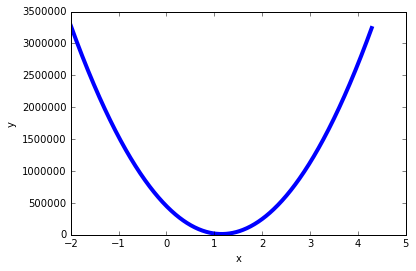

In [7]:
theta0 = 0
theta1 = np.arange(-2, 4.3, 0.01)
squared_errors = []
for t in theta1:
    predictions = theta0 + t * x
    squared_errors.append(np.sum(np.square(y - predictions)))
introduction.plot(theta1, squared_errors, line=True)

It is very important to note here that this cost function is a **convex function**. A convex function is a function that, when several water drops are dropped on it, they all slide thru the function and merge in the buttom creating one small pool :)
If our function looked like the function bellow, the drops would end in different places creating several small pools. That is not a convex function.

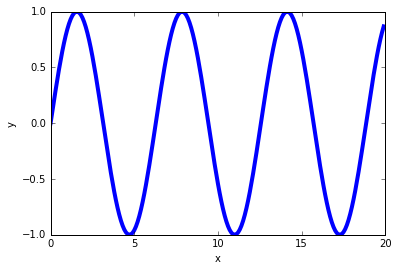

In [8]:
x_ = np.arange(0, 20, 0.1)
introduction.plot(x_, np.sin(x_), line=True)

Machine Learning is mostly about modeling a dataset by creating a convex error function and minimizing it.

Since the Least Squares Error uses the squares of the residuals, it penalizes heavily on large residuals, and not so much on small residuals.

Another popular cost function used in regression is the **Huber loss**, which looks like this

## Gradient descent

Now that we understand cost functions, we can look into how to minimize them. Gradient descent is an algorithm that iterates (i.e. "walks") thru a functions until it reaches a minimum value. The algorithm starts with a solution located at a random point on the cost function $J(\theta_0, \theta_1)$ and does the following:

1) calculate the slope of $J(\theta_0, \theta_1)$
2) update the current solution by moving it over $J(\theta_0, \theta_1)$ in the oposite direction of the slope.

The algorithm does 1) and 2) until $J(\theta_0, \theta_1)$ stops changing (in practice this means $J(\theta_0, \theta_1)$ changes very little).

We won't implement gradient descent in this class, but it's good that you have an intuition of how this optimization algorithm works.

## Implementing a linear regression machine learning algorithm using scikit learn

scikit learn is a cool Python package. It lets us implement complex algortithms without dealing with the low level implementation details like gradient descent. However we need to know how it works under the hoods so we can tune our algorithms wisely if they don't perform well.

The main scikit learn class we will use is called SGDRegressor. You can check the full API [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html), but the important bits are:


## Linear data

Using the dataset saved in x and y, In the below box, write your code. Save your predictions in an array called **predictions**.

In [9]:
model = introduction.SGDRegressor(loss='squared_loss',  n_iter=10, eta0=0.0001)
model.fit(x, y)

predictions = model.predict(x)

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Let's see how accurate your model is.

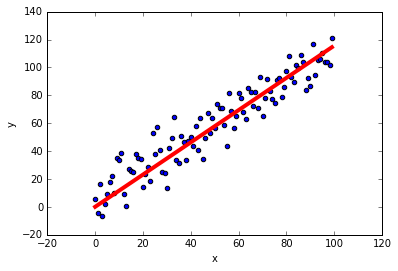

In [10]:
introduction.plot(x, y, predictions)

## Outlier linear data

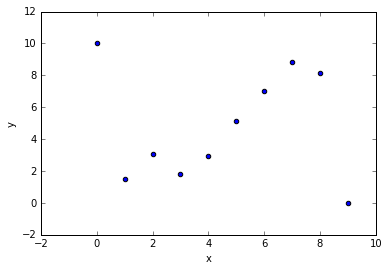

In [11]:
x, y = introduction.generate_linear_data(slope=1, intercept=0, noise_std=1, max_x=10)
y[0] = 10
y[y.shape[0]-1] = 0
introduction.plot(x, y)

In [12]:
model = introduction.SGDRegressor(loss='huber', eta0=0.01, n_iter=10000)
model.fit(x, y)
predictions = model.predict(x)

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


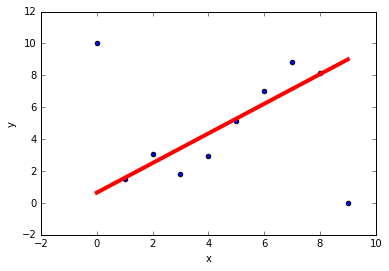

In [13]:
introduction.plot(x, y, predictions)

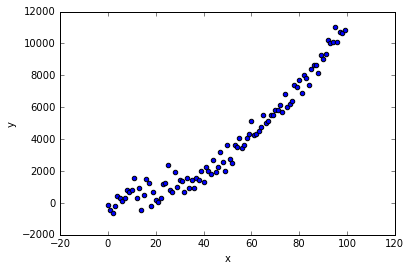

/Library/Python/2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


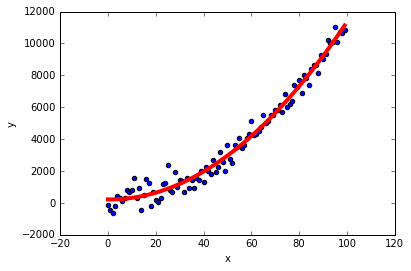

In [14]:
# Quadratic data
x, y = introduction.generate_quadratic_data(a=1, b=10, c=1, noise_std=500)
introduction.plot(x, y)

##################################################################
#################### START YOUR CODE HERE ########################
##################################################################
X = np.hstack((x**2, x))
model = introduction.LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
##################################################################
#################### END YOUR CODE HERE ##########################
##################################################################
introduction.plot(x, y, predictions)

ValueError: x and y must be the same size

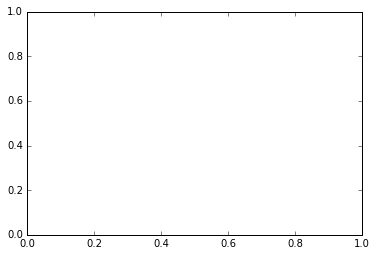

In [15]:
#### SCALING EXAMPLE
x, y = introduction.generate_unscaled_data(coefs=[1,1], intercept=1, noise_std=10)
introduction.plot(x, y)

##################################################################
#################### START YOUR CODE HERE ########################
##################################################################
X = np.hstack((x**2, x))
model = introduction.LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
##################################################################
#################### END YOUR CODE HERE ##########################
##################################################################
introduction.plot(x, y, predictions)